In [1]:
import os
import cv2
import pickle

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

In [2]:
from multispectral_analysis import *
from multispectral_image import *

In [3]:
TIFF_IMGS_DIR = "./outFolder/Processed_1/Survey3W_RGN/TIFF/Sensor_Response_Corrected_Images"

In [4]:
tiff_filenames = list(filter(lambda f: f.endswith(".tif"), os.listdir(TIFF_IMGS_DIR)))
tiff_filenames

['2024_0216_033506_151.tif',
 '2024_0216_033509_153.tif',
 '2024_0216_033511_155.tif',
 '2024_0216_033514_157.tif',
 '2024_0216_033516_159.tif']

In [5]:
multispectral_images = []
for filename in tiff_filenames:
    filepath = os.path.join(TIFF_IMGS_DIR, filename)
    multispectral_images.append(MultispectralRGNImage.from_multispectral_image(load_multispectral_image(filepath)))
print(f"Loaded {len(multispectral_images)} images.")

/home/anaximeno/miniconda3/envs/MapirS3/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Loaded 5 images.


### Training the KMeans Segmentation Model

In [6]:
training_data = []

for mimage in multispectral_images:
    ndvi_image_band = zero_one_norm(mimage.ndvi().image)
    gndvi_image_band = zero_one_norm(mimage.gndvi().image)
    nir_image_band = zero_one_norm(mimage.nir_band)

    flat_data = np.empty((IMAGE_HEIGHT * IMAGE_WIDTH, 3))

    for i, band in enumerate((ndvi_image_band, gndvi_image_band, nir_image_band)):
        flat_data[:, i-1] = band.flatten()

    training_data.append(flat_data)

In [7]:
kmeans_model = KMeans(n_clusters=2, random_state=18)

for flat in training_data:
    kmeans_model.fit(flat)

In [8]:
kmeans_model.cluster_centers_

array([[0.7248885 , 0.21263881, 0.79449415],
       [0.49699226, 0.16179297, 0.5415636 ]])

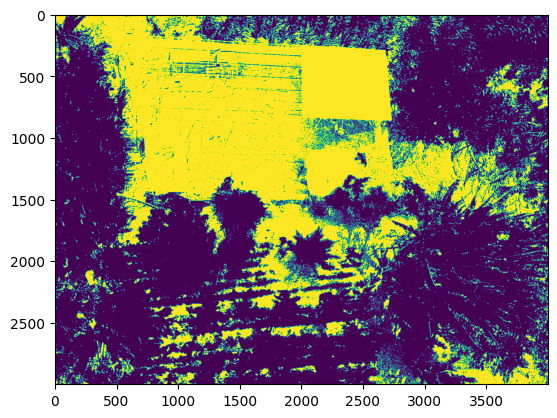

In [9]:
cluster = clusterize_multispectral_image(kmeans_model, multispectral_images[-1])
plt.imshow(cluster.reshape((IMAGE_HEIGHT, IMAGE_WIDTH)))

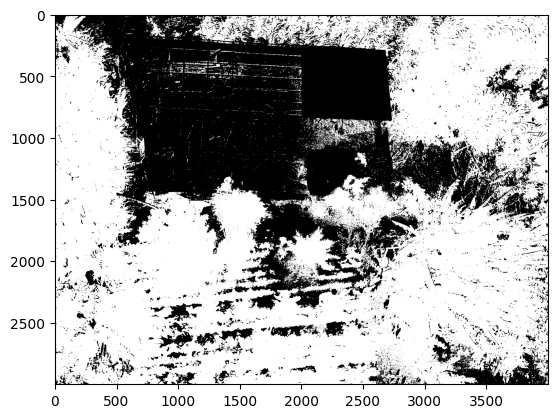

In [10]:
plt.imshow(cluster.reshape((IMAGE_HEIGHT, IMAGE_WIDTH)), cmap="Greys")

In [7]:
KMEANS_MODEL_VERSION = "1.0"
KMEANS_MODEL_NAME = "multispectral_vegiband_kmeans_model"

model_full_name = f"{KMEANS_MODEL_NAME}-v{KMEANS_MODEL_VERSION}.pkl"
model_full_name

'multispectral_vegiband_kmeans_model-v1.0.pkl'

In [9]:
with open(model_full_name, 'wb') as file:
    pickle.dump(kmeans_model, file)

if os.path.exists(model_full_name): print(f"Model {model_full_name!r} was successfuly saved!")

Model 'multispectral_vegiband_kmeans_model-v1.0.pkl' was successfuly saved!


### Water Stress Analysis

In [8]:
with open(model_full_name, 'rb') as file:
    loaded_model = pickle.load(file)
print(f"Loaded model {model_full_name!r} => {loaded_model}")

Loaded model 'multispectral_vegiband_kmeans_model-v1.0.pkl' => KMeans(n_clusters=2, random_state=18)


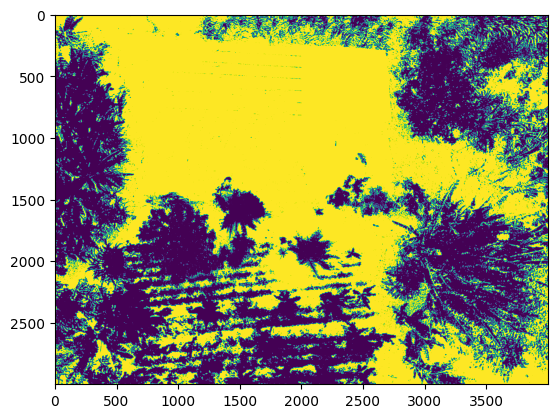

In [9]:
mim = multispectral_images[-1]
clusterized = clusterize_multispectral_image(loaded_model, mim)
mask = clusterized.reshape((IMAGE_HEIGHT, IMAGE_WIDTH))
mask = np.logical_not(mask).astype(np.int8)
plt.imshow(mask)

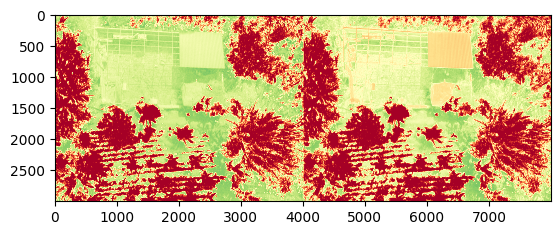

In [10]:
mim_ndvi = mim.ndvi()
mim_gndvi = mim.gndvi()

ndvi_image_normalized = (mim_ndvi.image * 0.5 + 0.5) * mask * (2**16 - 1)
gndvi_image_normalized = (mim_gndvi.image * 0.5 + 0.5) * mask * (2**16 - 1)

mim_ndvi_norm = MultispectralImage(ndvi_image_normalized.astype(np.uint16), mim_ndvi.metadata)
mim_gndvi_norm = MultispectralImage(gndvi_image_normalized.astype(np.uint16), mim_gndvi.metadata)

plt.imshow(np.hstack([mim_ndvi_norm.image, mim_gndvi_norm.image]), cmap='RdYlGn')

In [11]:
save_multispectral_image(mim_ndvi_norm, "./outFolder/ndvi.tif")
save_multispectral_image(mim_gndvi_norm, "./outFolder/gndvi.tif")
save_multispectral_image(mim, "./outFolder/image.tif")

/home/anaximeno/miniconda3/envs/MapirS3/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [10]:
STORE_PATH = "./outFolder/Processed_1/Analyzed"

if not os.path.exists(STORE_PATH):
    os.mkdir(STORE_PATH)

for i, mimg in enumerate(multispectral_images):
    clusterized = clusterize_multispectral_image(loaded_model, mimg)
    mask = clusterized.reshape((IMAGE_HEIGHT, IMAGE_WIDTH))
    mask = np.logical_not(mask).astype(np.int8)
    ndvi, gndvi = mimg.ndvi(), mimg.gndvi()

    ndvi_image_normalized = (ndvi.image * 0.5 + 0.5) * mask * (2**16 - 1)
    gndvi_image_normalized = (gndvi.image * 0.5 + 0.5) * mask * (2**16 - 1)

    ndvi_norm = MultispectralImage(ndvi_image_normalized.astype(np.uint16), ndvi.metadata)
    gndvi_norm = MultispectralImage(gndvi_image_normalized.astype(np.uint16), gndvi.metadata)

    save_multispectral_image(ndvi_norm, f"{STORE_PATH}/img_{i+1}_ndvi_unnorm.tif")
    save_multispectral_image(gndvi_norm, f"{STORE_PATH}/img_{i+1}_gndvi_unnorm.tif")
    save_multispectral_image(mimg, f"{STORE_PATH}/img_{i+1}.tif")

/home/anaximeno/miniconda3/envs/MapirS3/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/anaximeno/miniconda3/envs/MapirS3/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
/home/anaximeno/miniconda3/envs/MapirS3/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = wri